## 3. Training & Test AggMapNet on Country-Specific MEGMA Fmaps

In this section, we will introduce how to employ the CNN-based AggMapNet to train CRC detection models using the `megma` generated **2D-microbiomeprints (Fmaps)**. The CRC dection model is a classfication model because we have the binary labels (CRCs or CTRs) in our data. Same as the Fmaps generation, we can use the study to stduy transfer(STST) method to test the performance of our model.

Note that in the STST experiment, the Fmaps can be transformed by a country-specific `megma` (fitted or trained by one country unlabelled metagenomic data) or an overall `megma` (fitted or trained by all unlabelled metagenomic data), becuase **MEGMA** is an unsupervised learning method and only needs to be fitted on the unlabelled data.

First of all, let's try to explore the Fmaps transformed by a country-specific `megma` performance. Specifically, we are going to train the Fmaps generation model `MEGMA` (unsupervised model) and classficaition model `AggMapNet` (supervised model) based on one country data, and then we will test the performance of the model on the rest of the countries. 

### Traning the country-specific `MEGMA` and `AggMapNet` model

In [726]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc as calculate_auc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

from aggmap import AggMap, AggMapNet
from aggmap import show, loadmap

np.random.seed(123) #just for reaptable results

save_dir = './model_results_1'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [727]:
## megma parameters
metric = 'correlation' #distance metric
cluster_channels = 5 #channel number
emb_method = 'umap' #embedding method
minv = 1e-8 #minimal value for log-transform
scale_method = 'standard' #data scaling method

megma_all = loadmap('./megma.all')

## AggMapNet parameters
epochs = 20 #number of epochs
lr = 1e-4 #learning rate
batch_size = 1 #batch size
conv1_kernel_size = 5 #kernal size of the first cnn layer

def train(train_country, megma = None):
    
    url = 'https://raw.githubusercontent.com/shenwanxiang/bidd-aggmap/master/docs/source/_example_MEGMA/dataset/'
    dfx_vector = pd.read_csv(url + '%s_dfx.csv' % train_country, index_col='Sample_ID')
    dfx_vector = np.log(dfx_vector + minv)
    dfy = pd.read_csv(url + '%s_dfy.csv' % train_country, index_col='Sample_ID')

    if megma is None:
        # fit unsupervised megma & transform data
        megma = AggMap(dfx_vector, metric=metric, by_scipy=True)
        megma = megma.fit(cluster_channels = cluster_channels, 
                          emb_method = emb_method, 
                          var_thr = 3.0, ## Should be optimized by each megma based on model performance, such as 1, 2, 4, 8, 10, ..
                          verbose=0)
        
    X = megma.batch_transform(dfx_vector.values, 
                              scale_method = scale_method)
    Y = pd.get_dummies(dfy.Group).values
    
    # fit AggMapNet
    clf = AggMapNet.MultiClassEstimator(epochs = epochs,  
                                        batch_size = batch_size, 
                                        lr = lr, 
                                        conv1_kernel_size = conv1_kernel_size,
                                        verbose = 0, gpuid = 1)
    clf.fit(X, Y)
    
    ## save unsupervised megma and supervised AggMapNet model
    megma_save_name = os.path.join(save_dir, 'megma.%s.mp' % train_country)
    model_save_name = os.path.join(save_dir, 'aggmapnet.%s.h5' % train_country)
    
    clf.save_model(model_save_name)
    megma.save(megma_save_name)

    return clf, megma

### Test model performance using STST strategy

In [728]:
def test(megma, clf, test_country):
    url = 'https://raw.githubusercontent.com/shenwanxiang/bidd-aggmap/master/docs/source/_example_MEGMA/dataset/'
    dfx_vector = pd.read_csv(url + '%s_dfx.csv' % test_country, index_col='Sample_ID')
    dfx_vector = np.log(dfx_vector + minv)
    dfy = pd.read_csv(url + '%s_dfy.csv' % test_country, index_col='Sample_ID')
    testX = megma.batch_transform(dfx_vector.values, 
                                  scale_method = scale_method)
    testY = pd.get_dummies(dfy.Group).values 
    y_true = testY[:,0]
    y_pred = clf.predict(testX)[:,0] 
    y_score = clf.predict_proba(testX)[:,0]

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    acc = (tp + tn) / sum([tn, fp, fn, tp])
    sensitivity = tp / sum([tp, fn])
    specificity = tn / sum([tn, fp])
    roc_auc = roc_auc_score(y_true, y_score)
    precision = tp / sum([tp, fp])
    recall =  tp / sum([tp, fn]) #equals to sensitivity
    
    res = {'test_country':test_country,
           'accuracy':acc, 
           'roc_auc':roc_auc,
           'sensitivity': sensitivity, 
           'specificity': specificity,
           'precision':precision,
           'recall':recall}
    return res

def get_non_diag_mean(df):
    v = df.values.copy()
    np.fill_diagonal(v, np.nan)
    mean =  pd.DataFrame(v, columns = df.columns, index = df.index).mean(axis=1).round(2)
    std = pd.DataFrame(v, columns = df.columns, index = df.index).std(axis=1).round(2)
    return mean,std

In [729]:
countries = ['CHN', 'AUS', 'DEU', 'FRA', 'USA'] # 
#megma_all = loadmap('./megma.all')
all_res = []
for train_country in countries:
    clf, megma = train(train_country, megma = None)
    for test_country in countries:
        res = test(megma, clf, test_country)
        res.update({'train_country':train_country})
        all_res.append(res)

df = pd.DataFrame(all_res)
dfres = pd.crosstab(index = df.train_country, columns= df.test_country, values= df.roc_auc, aggfunc = np.mean)

cols = ['FRA', 'AUS', 'CHN', 'USA', 'DEU']
ourmodel_df1 = dfres[cols].loc[cols].round(3)
ourmodel_df1

2022-08-12 18:19:20,046 - INFO - [bidd-aggmap] - Calculating distance ...


100%|###############################################################################| 849/849 [00:00<00:00, 5665.11it/s]

2022-08-12 18:19:20,212 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...


2022-08-12 18:19:20,661 - INFO - [bidd-aggmap] - Applying grid assignment of feature points, this may take several minutes(1~30 min)
2022-08-12 18:19:20,979 - INFO - [bidd-aggmap] - Finished


100%|###############################################################################| 128/128 [00:00<00:00, 2675.38it/s]

MultiClassEstimator(batch_norm=False, batch_size=1, conv1_kernel_size=5,
                    dense_avf='relu', dense_layers=[128], dropout=0.0,
                    epochs=20, gpuid='1', last_avf='softmax',
                    loss='categorical_crossentropy', lr=0.0001, metric='ACC',
                    monitor='val_loss', n_inception=2,
                    name='AggMap MultiClass Estimator', patience=10000,
                    random_state=32, verbose=0)


saving model to ./model_results_1/aggmapnet.CHN.h5


100%|###############################################################################| 104/104 [00:00<00:00, 1691.01it/s]


2022-08-12 18:19:55,492 - INFO - [bidd-aggmap] - Calculating distance ...


100%|###############################################################################| 849/849 [00:00<00:00, 5612.41it/s]

2022-08-12 18:19:55,660 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...


2022-08-12 18:19:56,180 - INFO - [bidd-aggmap] - Applying grid assignment of feature points, this may take several minutes(1~30 min)
2022-08-12 18:19:56,508 - INFO - [bidd-aggmap] - Finished


100%|###############################################################################| 109/109 [00:00<00:00, 2482.48it/s]

MultiClassEstimator(batch_norm=False, batch_size=1, conv1_kernel_size=5,
                    dense_avf='relu', dense_layers=[128], dropout=0.0,
                    epochs=20, gpuid='1', last_avf='softmax',
                    loss='categorical_crossentropy', lr=0.0001, metric='ACC',
                    monitor='val_loss', n_inception=2,
                    name='AggMap MultiClass Estimator', patience=10000,
                    random_state=32, verbose=0)


saving model to ./model_results_1/aggmapnet.AUS.h5


100%|###############################################################################| 104/104 [00:00<00:00, 2245.48it/s]


2022-08-12 18:20:23,774 - INFO - [bidd-aggmap] - Calculating distance ...


100%|###############################################################################| 849/849 [00:00<00:00, 5664.05it/s]

2022-08-12 18:20:23,939 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...


2022-08-12 18:20:24,468 - INFO - [bidd-aggmap] - Applying grid assignment of feature points, this may take several minutes(1~30 min)
2022-08-12 18:20:24,776 - INFO - [bidd-aggmap] - Finished


100%|###############################################################################| 120/120 [00:00<00:00, 2694.31it/s]

MultiClassEstimator(batch_norm=False, batch_size=1, conv1_kernel_size=5,
                    dense_avf='relu', dense_layers=[128], dropout=0.0,
                    epochs=20, gpuid='1', last_avf='softmax',
                    loss='categorical_crossentropy', lr=0.0001, metric='ACC',
                    monitor='val_loss', n_inception=2,
                    name='AggMap MultiClass Estimator', patience=10000,
                    random_state=32, verbose=0)


saving model to ./model_results_1/aggmapnet.DEU.h5


100%|###############################################################################| 104/104 [00:00<00:00, 1429.33it/s]


2022-08-12 18:20:55,057 - INFO - [bidd-aggmap] - Calculating distance ...


100%|###############################################################################| 849/849 [00:00<00:00, 5696.70it/s]

2022-08-12 18:20:55,230 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...


2022-08-12 18:20:55,782 - INFO - [bidd-aggmap] - Applying grid assignment of feature points, this may take several minutes(1~30 min)
2022-08-12 18:20:56,362 - INFO - [bidd-aggmap] - Finished


100%|###############################################################################| 114/114 [00:00<00:00, 2151.18it/s]

MultiClassEstimator(batch_norm=False, batch_size=1, conv1_kernel_size=5,
                    dense_avf='relu', dense_layers=[128], dropout=0.0,
                    epochs=20, gpuid='1', last_avf='softmax',
                    loss='categorical_crossentropy', lr=0.0001, metric='ACC',
                    monitor='val_loss', n_inception=2,
                    name='AggMap MultiClass Estimator', patience=10000,
                    random_state=32, verbose=0)


saving model to ./model_results_1/aggmapnet.FRA.h5


100%|###############################################################################| 104/104 [00:00<00:00, 1537.21it/s]


2022-08-12 18:21:24,540 - INFO - [bidd-aggmap] - Calculating distance ...


100%|###############################################################################| 849/849 [00:00<00:00, 5664.88it/s]

2022-08-12 18:21:24,705 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...


2022-08-12 18:21:25,243 - INFO - [bidd-aggmap] - Applying grid assignment of feature points, this may take several minutes(1~30 min)
2022-08-12 18:21:25,458 - INFO - [bidd-aggmap] - Finished


100%|###############################################################################| 104/104 [00:00<00:00, 1930.66it/s]

MultiClassEstimator(batch_norm=False, batch_size=1, conv1_kernel_size=5,
                    dense_avf='relu', dense_layers=[128], dropout=0.0,
                    epochs=20, gpuid='1', last_avf='softmax',
                    loss='categorical_crossentropy', lr=0.0001, metric='ACC',
                    monitor='val_loss', n_inception=2,
                    name='AggMap MultiClass Estimator', patience=10000,
                    random_state=32, verbose=0)


saving model to ./model_results_1/aggmapnet.USA.h5


100%|###############################################################################| 104/104 [00:00<00:00, 2345.45it/s]


test_country,FRA,AUS,CHN,USA,DEU
train_country,,,,,
FRA,1.000,0.842,0.873,0.730,0.843
AUS,0.673,1.000,0.630,0.645,0.723
CHN,0.739,0.888,1.000,0.665,0.866
USA,0.663,0.801,0.761,1.000,0.791
DEU,0.774,0.723,0.798,0.735,1.000


In [730]:
countries = ['CHN', 'AUS', 'DEU', 'FRA', 'USA'] # 
all_res = []
for train_country in countries:
    clf, megma = train(train_country, megma = megma_all)

    for test_country in countries:
        res = test(megma, clf, test_country)
        res.update({'train_country':train_country})
        all_res.append(res)

df = pd.DataFrame(all_res)
dfres = pd.crosstab(index = df.train_country, columns= df.test_country, values= df.roc_auc, aggfunc = np.mean)

cols = ['FRA', 'AUS', 'CHN', 'USA', 'DEU']
ourmodel_df2 = dfres[cols].loc[cols].round(3)
ourmodel_df2

100%|###############################################################################| 128/128 [00:00<00:00, 1094.02it/s]


MultiClassEstimator(batch_norm=False, batch_size=1, conv1_kernel_size=5,
                    dense_avf='relu', dense_layers=[128], dropout=0.0,
                    epochs=20, gpuid='1', last_avf='softmax',
                    loss='categorical_crossentropy', lr=0.0001, metric='ACC',
                    monitor='val_loss', n_inception=2,
                    name='AggMap MultiClass Estimator', patience=10000,
                    random_state=32, verbose=0)
saving model to ./model_results_1/aggmapnet.CHN.h5


100%|###############################################################################| 109/109 [00:00<00:00, 1885.31it/s]


MultiClassEstimator(batch_norm=False, batch_size=1, conv1_kernel_size=5,
                    dense_avf='relu', dense_layers=[128], dropout=0.0,
                    epochs=20, gpuid='1', last_avf='softmax',
                    loss='categorical_crossentropy', lr=0.0001, metric='ACC',
                    monitor='val_loss', n_inception=2,
                    name='AggMap MultiClass Estimator', patience=10000,
                    random_state=32, verbose=0)
saving model to ./model_results_1/aggmapnet.AUS.h5


100%|###############################################################################| 120/120 [00:00<00:00, 2161.92it/s]


MultiClassEstimator(batch_norm=False, batch_size=1, conv1_kernel_size=5,
                    dense_avf='relu', dense_layers=[128], dropout=0.0,
                    epochs=20, gpuid='1', last_avf='softmax',
                    loss='categorical_crossentropy', lr=0.0001, metric='ACC',
                    monitor='val_loss', n_inception=2,
                    name='AggMap MultiClass Estimator', patience=10000,
                    random_state=32, verbose=0)
saving model to ./model_results_1/aggmapnet.DEU.h5


100%|###############################################################################| 114/114 [00:00<00:00, 1961.60it/s]


MultiClassEstimator(batch_norm=False, batch_size=1, conv1_kernel_size=5,
                    dense_avf='relu', dense_layers=[128], dropout=0.0,
                    epochs=20, gpuid='1', last_avf='softmax',
                    loss='categorical_crossentropy', lr=0.0001, metric='ACC',
                    monitor='val_loss', n_inception=2,
                    name='AggMap MultiClass Estimator', patience=10000,
                    random_state=32, verbose=0)
saving model to ./model_results_1/aggmapnet.FRA.h5


100%|###############################################################################| 104/104 [00:00<00:00, 1750.50it/s]


MultiClassEstimator(batch_norm=False, batch_size=1, conv1_kernel_size=5,
                    dense_avf='relu', dense_layers=[128], dropout=0.0,
                    epochs=20, gpuid='1', last_avf='softmax',
                    loss='categorical_crossentropy', lr=0.0001, metric='ACC',
                    monitor='val_loss', n_inception=2,
                    name='AggMap MultiClass Estimator', patience=10000,
                    random_state=32, verbose=0)
saving model to ./model_results_1/aggmapnet.USA.h5


100%|###############################################################################| 104/104 [00:00<00:00, 1385.75it/s]


test_country,FRA,AUS,CHN,USA,DEU
train_country,,,,,
FRA,1.000,0.873,0.853,0.753,0.909
AUS,0.759,1.000,0.732,0.761,0.882
CHN,0.789,0.817,1.000,0.773,0.888
USA,0.700,0.856,0.770,1.000,0.825
DEU,0.820,0.851,0.846,0.773,1.000


In [751]:
get_non_diag_mean(ourmodel_df1)

(train_country
 FRA    0.82
 AUS    0.67
 CHN    0.79
 USA    0.75
 DEU    0.76
 dtype: float64,
 train_country
 FRA    0.06
 AUS    0.04
 CHN    0.11
 USA    0.06
 DEU    0.03
 dtype: float64)

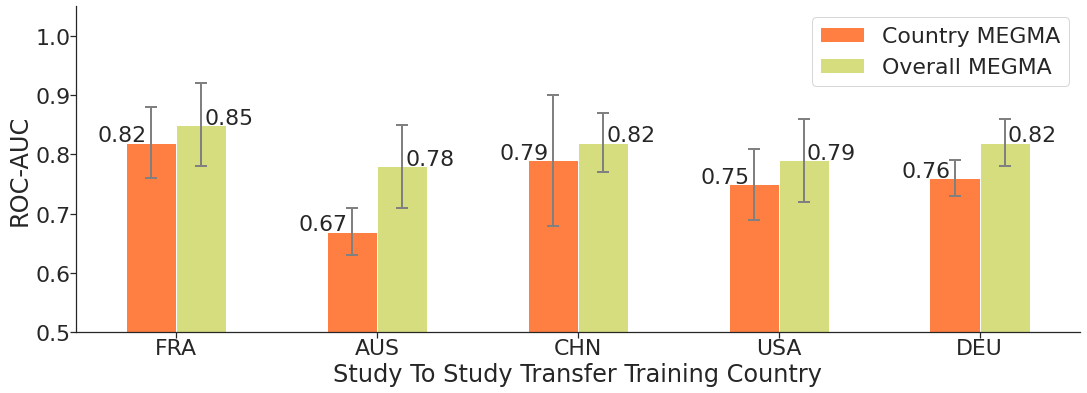

In [750]:
sns.set(style = 'white', font_scale=2)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,6), sharex = True, sharey = True)

y1 = get_non_diag_mean(ourmodel_df1)[0].to_frame(name = 'Country MEGMA')
y2 = get_non_diag_mean(ourmodel_df2)[0].to_frame(name = 'Overall MEGMA')

y1_err = get_non_diag_mean(ourmodel_df1)[1].to_frame(name = 'Country MEGMA')
y2_err = get_non_diag_mean(ourmodel_df2)[1].to_frame(name = 'Overall MEGMA')

y = y1.join(y2)
y_err = y1_err.join(y2_err)

color = sns.color_palette("rainbow_r", 5) #PiYG

y.plot(kind = 'bar',ax = ax, color = color, yerr= y_err,ylim = (0.5, 0.96), error_kw=dict(ecolor='gray', lw=2, capsize=6, capthick=2))
ax.set_ylabel('ROC-AUC')
#ax.set_title('Study To Study Transfer (STST) Average Performance')
ax.set_xlabel('Study To Study Transfer Training Country')

for x_, y_ in enumerate(y['Country MEGMA'].values):
    ax.annotate('%.2f' % y_, xy = (x_-0.39, y_+0.002), fontsize =22)

for  x_, y_ in enumerate(y['Overall MEGMA'].values):
    ax.annotate('%.2f' % y_, xy = (x_+0.14, y_+0.002), fontsize =22)
    
ax.set_xticklabels(labels = y.index,rotation=0, ha = 'center')
ax.set_ylim(0.5,1.05)

ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
sns.despine(top=True, right=True, left=False, bottom=False)


# fig.savefig('./results/STST_loso_aggmap_vs_lasso__comparasion_mean.pdf', bbox_inches='tight', dpi=400) 

Text(0.5, 6.199999999999996, 'Test country')

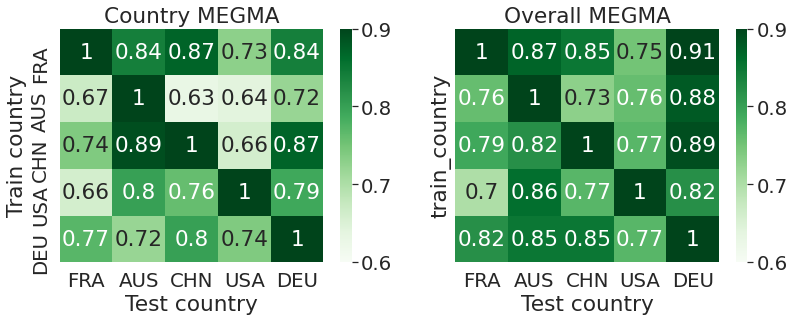

In [742]:
sns.set(style = 'white', font_scale=1.8)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,4.3), sharex=True, sharey=True)

ax1, ax2 = axes

sns.heatmap(ourmodel_df1.round(2), cmap = 'Greens',  ax = ax1, annot=True,  vmin = 0.6, vmax = 0.9,)
ax1.set_title("Country MEGMA")

sns.heatmap(ourmodel_df2.round(2), cmap = 'Greens',  ax = ax2, annot=True, vmin = 0.6, vmax = 0.9,)
ax2.set_title("Overall MEGMA")

ax1.set_ylabel('Train country')
# ax2.set_ylabel('Train country')

ax1.set_xlabel('Test country')
ax2.set_xlabel('Test country')